### Analyzing bumps

In [175]:
import pandas as pd
import seaborn as sns

from modules.plotting_scripts import plot_surprisals, plot_all_in_one

In [402]:
def count_bumps(diffs):
    if len(diffs) < 3:
        raise ValueError(f"Series length {len(diffs)} is less than the required length 3.")
    
    n_bumps = 0
    change = True

    # determine the sign at index 1
    # (True for negative, False for positive)
    initial_sign = diffs.iloc[1] < 0    

    # count the number of times the sign changes into the opposite
    for diff in diffs.iloc[2:]:
        current_sign = diff < 0
        if current_sign == initial_sign:
            change = True
        elif current_sign != initial_sign and change:
            n_bumps += 1
            change = False

    # if the sign at the last step is the same as the initial sign, add 1 to the number of bumps
    last_sign = diffs.iloc[-1] < 0
    n_bumps += 1 if last_sign == initial_sign else 0

    return n_bumps

In [403]:
def bumpiness_level(diffs, threshold=0.5):
    if len(diffs) < 3:
        raise ValueError(f"Series length {len(diffs)} is less than the required length 3.")
    
    level = 0
    change = True
    bump_depth = 0

    # determine the sign at index 1
    # (True for negative, False for positive)
    initial_sign = diffs.iloc[1] < 0    

    # count the number of times the sign changes into the opposite
    for diff in diffs.iloc[2:]:
        current_sign = diff < 0
        if current_sign == initial_sign:
            change = True
            bump_depth = 0
        elif current_sign != initial_sign and change:   # potential bump
            bump_depth += abs(diff)
            # only consider a bump if its depth is greater than a given threshold
            if bump_depth >= threshold:
                level += 1
                change = False

    return level

In [404]:
wikitext_surprisals = '../results/lexique_results/shuffled_bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

surprisals = (surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

surprisals.insert(0, 'Token', surprisals.pop('Token'))

/tmp/ipykernel_3298801/1068651439.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0),


In [421]:
token_bumps = surprisals.groupby('Token').agg(**{
    'Bumps': ('MeanSurprisalDiff', count_bumps),
    'BumpinessLevel': ('MeanSurprisalDiff', bumpiness_level)
    }).reset_index()

token_bumps

,Token,Bumps,BumpinessLevel
0,a,9,0
1,aa,9,5
2,abandon,9,7
3,abandoned,8,4
4,abandoning,7,4
...,...,...,...
9073,zone,10,2
9074,zones,10,5
9075,zoo,7,7
9076,zoom,9,5


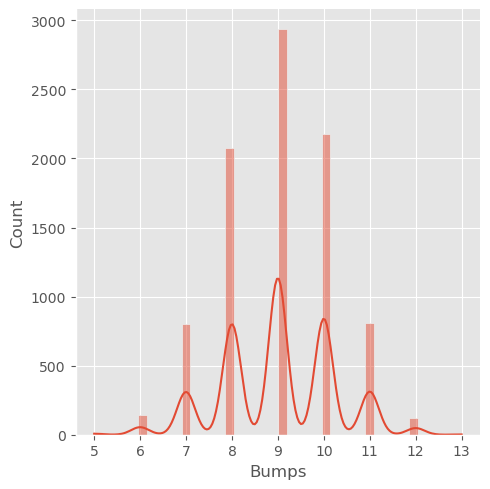

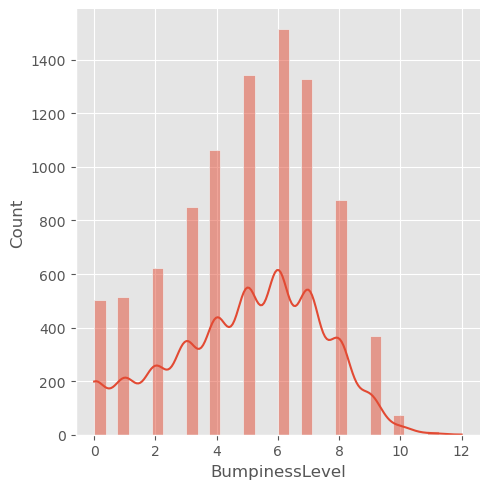

In [423]:
sns.displot(data=token_bumps, x='Bumps', kde=True)
sns.displot(data=token_bumps, x='BumpinessLevel', kde=True)

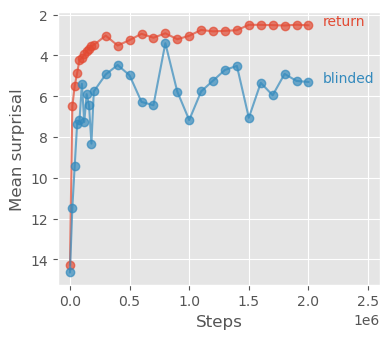

In [441]:
bumpiness_0 = token_bumps[token_bumps.BumpinessLevel == 0].Token.sample(1).tolist()
bumpiness_6 = token_bumps[token_bumps.BumpinessLevel == 6].Token.sample(1).tolist()
plot_all_in_one(bumpiness_0 + bumpiness_6, surprisals)

**Remarks:**
1. **Problem**: Only considering the sign is not enough. For example in the case of 'a' and 'aa', they both have the same number of bumps but the plot of 'a' is much smoother than 'aa'.
2. **Solution**: assigning to each curve a bumpiness level, computed as follows: when a potential bump is identified (when the curve changes direction) we add up the diffs in that direction and if the sum is greater than a threshold, we add 1 to the bumpiness level.

**Question:** What is the threshold for considering a plot as bumpy or not?

In [445]:
selection = ['killing', 'weakly', 
             'whose', 'egg', 
             'participated', 'beneficial', 
             'years', 'shadowed', 
             'begin', 'reflective', 
             'preferring', 'jealous', 
             'reaching', 'gross']

token_bumps[token_bumps.Token.isin(selection)].sort_values(['Bumps', 'BumpinessLevel']).reset_index(drop=True)

,Token,Bumps,BumpinessLevel
0,killing,6,1
1,weakly,6,5
2,whose,7,1
3,egg,7,6
4,participated,8,0
5,beneficial,8,7
6,years,9,0
7,shadowed,9,5
8,begin,10,2
9,reflective,10,7


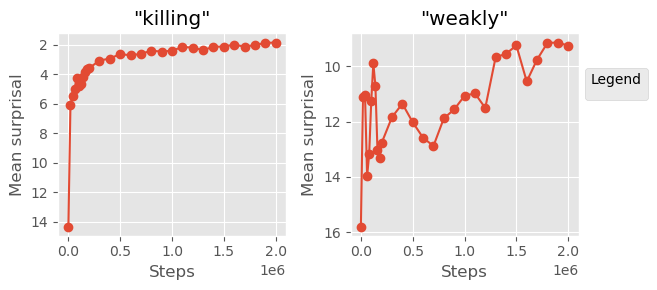

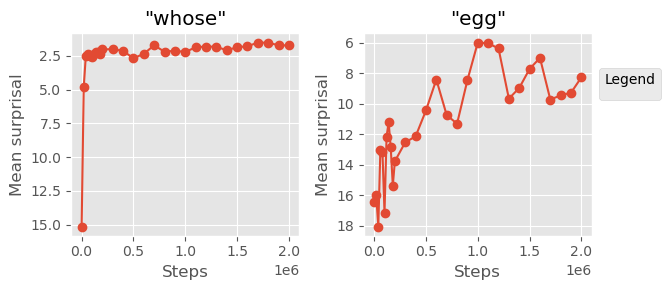

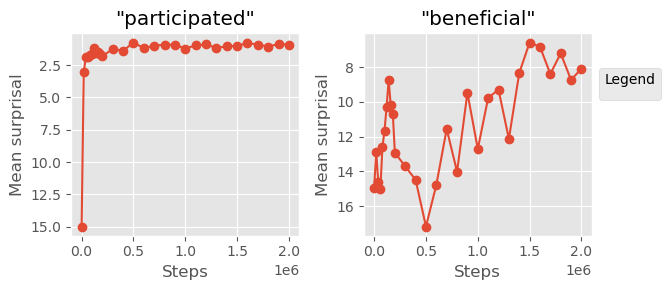

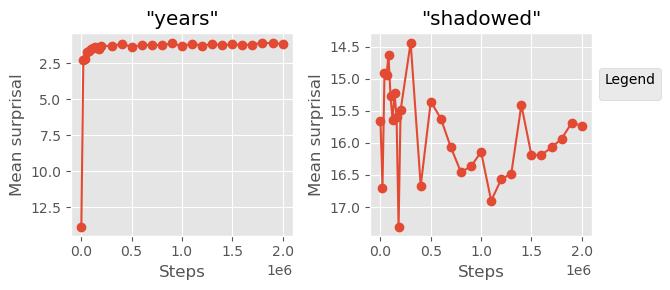

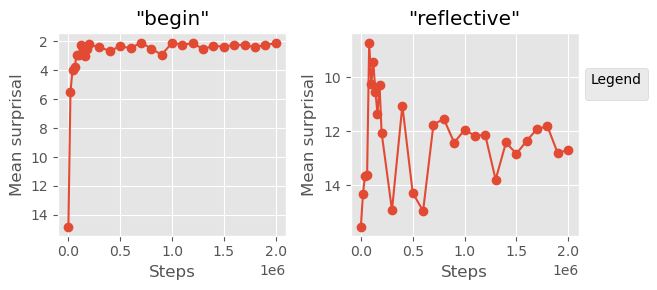

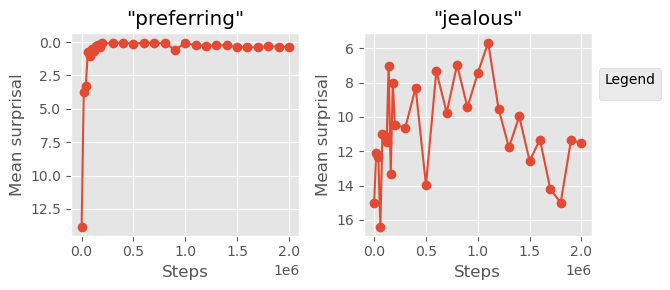

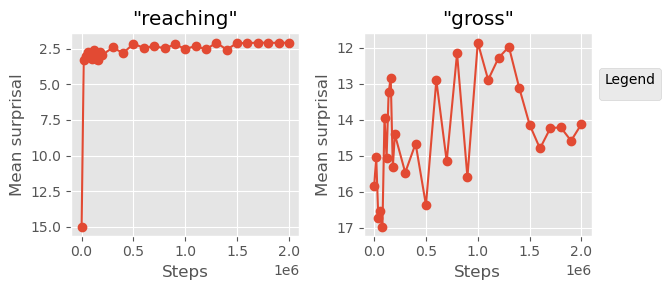

{}

In [11]:
plot_surprisals(['killing', 'weakly'], surprisals)           # 6 bumps, bumpiness levels: 1 and 5
plot_surprisals(['whose', 'egg'], surprisals)                # 7 bumps, bumpiness levels: 1 and 6
plot_surprisals(['participated', 'beneficial'], surprisals)  # 8 bumps, bumpiness levels: 0 and 7
plot_surprisals(['years', 'shadowed'], surprisals)           # 9 bumps, bumpiness levels: 0 and 5
plot_surprisals(['begin', 'reflective'], surprisals)         # 10 bumps, bumpiness levels: 2 and 7
plot_surprisals(['preferring', 'jealous'], surprisals)       # 11 bumps, bumpiness levels: 0 and 9
plot_surprisals(['reaching', 'gross'], surprisals)           # 12 bumps, bumpiness levels: 1 and 9